"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

In [3]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

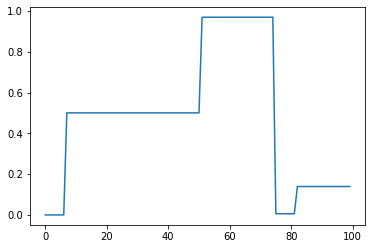

In [129]:
import scipy as sp
N = 2
K = 5
alpha = 5
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
#plt.matshow(w); plt.colorbar()

lens = w[0]
lens = lens / lens.sum()
changes = np.cumsum(lens)
rate = np.random.random(len(lens)-1)
total_len = 100
fin_changes = np.vectorize(np.int)(total_len * changes)
x = np.zeros(total_len)
for num, this_rate in enumerate(rate):
    x[fin_changes[num]:fin_changes[num+1]] = this_rate
plt.plot(x)

In [130]:
length = total_len
idx = np.arange(length)
changes = 10

with pm.Model() as dpp_model:
    
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda_latent', a_lambda, b_lambda, shape = changes+1)  
    
    
    #alpha = pm.HalfCauchy('alpha',5)
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape = changes)
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * total_len))
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    lambda_ = pm.Deterministic('lambda_',
                               pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0))
    # Add observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=x)

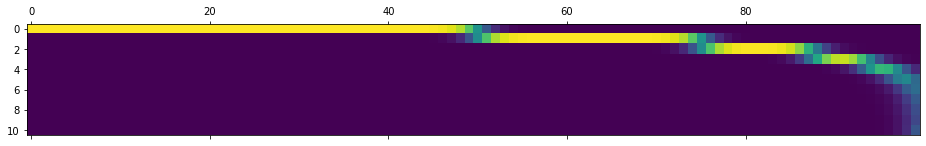

In [131]:
plt.matshow(weight_stack.tag.test_value, aspect='auto')

In [132]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 100)

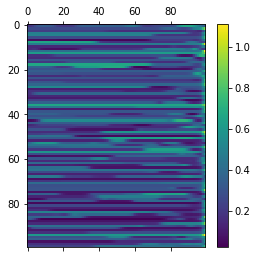

In [133]:
plt.matshow(spp['lambda_'], aspect='auto');plt.colorbar()

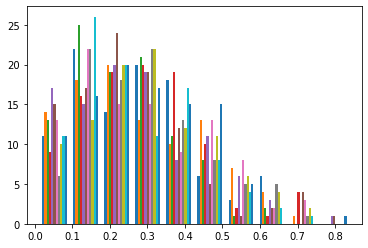

In [134]:
plt.hist(spp['lambda_latent']);

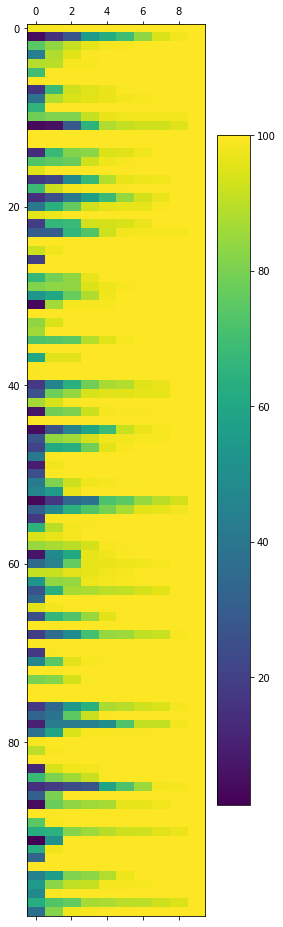

In [135]:
plt.matshow(spp['tau'], aspect='auto');plt.colorbar()

(array([38., 31., 17.,  3.,  1.,  6.,  1.,  2.,  0.,  1.]),
 array([0.00573725, 0.56123355, 1.11672986, 1.67222616, 2.22772247,
        2.78321877, 3.33871508, 3.89421138, 4.44970769, 5.005204  ,
        5.5607003 ]),
 <BarContainer object of 10 artists>)

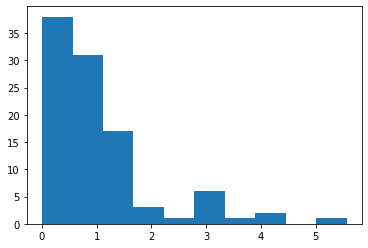

In [136]:
plt.hist(spp['alpha'])

In [137]:
#spp['tau']

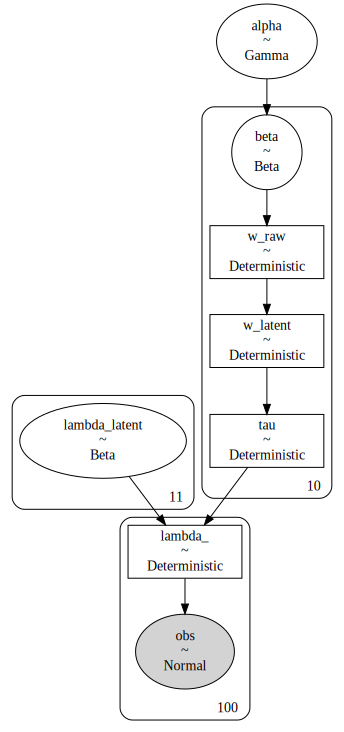

In [138]:
pm.model_to_graphviz(dpp_model)

In [139]:
with dpp_model:
    dpp_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, lambda_latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7038311305835957, but should be close to 0.8. Try to increase the number of tuning steps.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6999658389027625, but should be close to 0.8. Try to increase the number of tuning steps.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5078247776844698, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

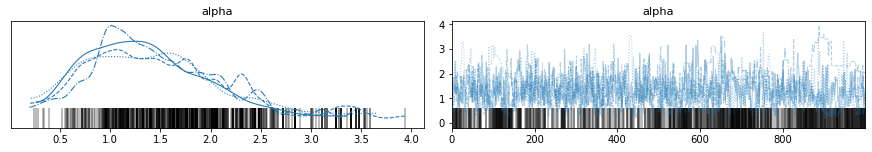

In [140]:
with dpp_model:
    pm.traceplot(dpp_trace, var_names = 'alpha');

In [141]:
dpp_ppc = pm.sample_posterior_predictive(dpp_trace, samples = 200, model = dpp_model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


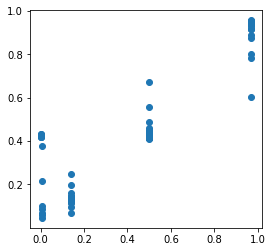

In [142]:
plt.scatter(x, dpp_ppc['obs'].mean(axis=0))
plt.gca().set_aspect('equal')

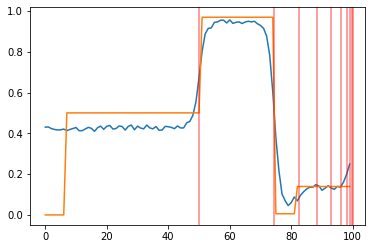

In [143]:
plt.plot(dpp_ppc['obs'].mean(axis=0))
plt.plot(x)
for val in dpp_trace['tau'].mean(axis=0):
    plt.axvline(val, color = 'red', alpha = 0.5)

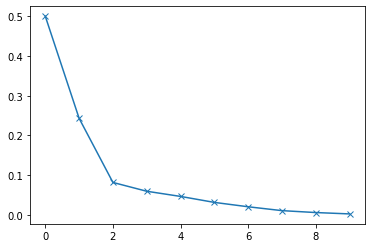

In [144]:
plt.plot(np.sort(dpp_trace['w_latent'].mean(axis=0))[::-1],'-x')